# Time-Frequency Representation Heatmaps

Subjects E1-7 had tfr analysis done on them and then separated into 1 of 6 different frequency bands:
- delta
- theta
- alpha
- beta
- gamma
- highgamma

In [4]:
# auto-format every cell to black
%load_ext lab_black

In [47]:
import numpy as np
import pandas as pd
import mne
import os
import json
import os.path as op
from pathlib import Path
import collections
from pprint import pprint
from natsort import natsorted

from sklearn.datasets import make_spd_matrix
from mne.io import RawArray
from mne import create_info
from mne.time_frequency import read_tfrs, AverageTFR
from mne_bids import BIDSPath, get_entity_vals, read_raw_bids
import mne

mne.utils.use_log_level("error")

import ptitprince as pt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

import pingouin as pg
import dabest
from hyppo.independence import MGC
from hyppo.ksample import KSample

from eztrack.io.base import _add_desc_to_bids_fname, concatenate_derivs
from eztrack.io import read_derivative_npy, DerivativeArray, create_deriv_info
from eztrack.utils import Normalize
from eztrack.viz import _load_turbo, generate_heatmap
from eztrack.posthoc.hypo import compute_null

_load_turbo()

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
np.random.seed(12345)

In [7]:
import warnings

warnings.filterwarnings("ignore")

In [8]:
def get_resected_chs(subject, root):
    bids_path = BIDSPath(
        subject=subject, root=root, suffix="channels", extension=".tsv"
    )
    ch_fpaths = bids_path.match()

    # read in sidecar channels.tsv
    channels_pd = pd.read_csv(ch_fpaths[0], sep="\t")
    description_chs = pd.Series(
        channels_pd.description.values, index=channels_pd.name
    ).to_dict()
    resected_chs = [
        ch for ch, description in description_chs.items() if description == "resected"
    ]
    return resected_chs

In [9]:
def load_concat_derivs(deriv_path, subject, session, desc, tasks=None):
    # get all the subject/sessions in the derivative path
    subjects = get_entity_vals(deriv_path, "subject")
    ignore_subjects = [sub for sub in subjects if sub != subject]
    sessions = get_entity_vals(deriv_path, "session", ignore_subjects=ignore_subjects)
    ignore_sessions = [ses for ses in sessions if ses != session]

    # store all derivatives found in a list
    derivs = []
    onsets = []
    descriptions = []
    prevlen = 0

    if session == "extraoperative":
        tasks = ["interictal", "ictal"]

    if tasks is None:
        # get all the tasks associated if not passed in
        tasks = get_entity_vals(
            deriv_path,
            "task",
            ignore_subjects=ignore_subjects,
            ignore_sessions=ignore_sessions,
        )
    for task in tasks:
        # get all file paths for this subject
        search_str = f"*ses-{session}*task-{task}*desc-{desc}*.json"
        deriv_fpaths = natsorted(list((deriv_path / f"sub-{subject}").glob(search_str)))

        #         print(f'Found {len(deriv_fpaths)} derivative file paths')

        for idx, deriv_fpath in enumerate(deriv_fpaths):
            deriv = read_derivative_npy(deriv_fpath, preload=True, verbose=False)

            if "ch_axis" not in deriv.info:
                deriv.info["ch_axis"] = [0]
                rowderiv.info["ch_axis"] = [0]

            # create derivative structure
            onsets.append(prevlen + len(deriv))
            descriptions.append(f"ses-{session}-task-{task}-run-{idx+1}")
            prevlen += len(deriv)
            #         if derivative is None:
            #             derivative = deriv.copy()
            #             derivs.append(deriv.copy())
            #         else:
            # check that all channel names are ordered
            #                 if derivative.ch_names != deriv.ch_names:
            #                     deriv.reorder_channels(derivative.ch_names)
            #                     rowderiv.reorder_channels(derivative.ch_names)
            #                 assert derivative.ch_names == deriv.ch_names
            #                 derivative.append(deriv.copy())
            derivs.append(deriv.copy())
    return derivs, onsets, descriptions

# Define Paths and Parameters for Analysis

In [12]:
# paths to BIDS dataset / derivatives
root = Path("/Users/adam2392/OneDrive - Johns Hopkins/sickkids/")
# root = Path('/Users/adam2392/Dropbox/epilepsy_bids/')
deriv_root = root / "derivatives"

# where to save the data
figures_path = deriv_root / "figures" / "tfrmaps"

figures_path.mkdir(exist_ok=True)
# all session to analyze
sessions = ["extraoperative", "preresection", "intraresection", "postresection"]

# Load data for all subjects

In [13]:
# get all subjects analyze
subjects = get_entity_vals(root, "subject")

print(f"All subjects analyzed are: {subjects}")

All subjects analyzed are: ['E1', 'E3', 'E4', 'E5', 'E6', 'E7']


In [14]:
freq_bands = ["delta", "theta", "alpha", "beta", "gamma", "highgamma"]

In [100]:
subject = "E1"
session = "preresection"
task = "pre"
acquisition = "ecog"
run = "01"

# derivative experiment markers
reference = "average"
deriv_chain = Path("tfr") / reference / f"sub-{subject}"
deriv_path = deriv_root / deriv_chain

# the derivative ``desc`` entity description
desc = "delta"
threshold = None
baseline = False
apply_normalize = True

In [16]:
bids_path = BIDSPath(
    subject=subject,
    session=session,
    task=task,
    acquisition=acquisition,
    run=run,
    suffix="ieeg",
    extension=".h5",
    check=False,
)
deriv_fname = _add_desc_to_bids_fname(bids_path.basename, description=desc)
deriv_fpath = deriv_path / deriv_fname

power = read_tfrs(deriv_fpath)
print(power)
power = power[0]

[<AverageTFR | time : [0.000000, 320.123120], freq : [1.000000, 4.000000], nave : 1, channels : 98, ~490.7 MB>]


In [49]:
print(power.comment)
print(power.method)
print(power.info["subject_info"])
print(power.get_channel_types()[0])

delta
morlet-power
{'age': 'n/a', 'clinically_annotated_soz': 'right-frontal-lobe', 'engel_score': '3', 'hand': 0, 'intellectual-function': '77', 'months_follow_up': '24', 'outcome': 'F', 'participant_id': 'sub-E1', 'sex': 0, 'verbal-comprehension': '78', 'verbal-memory-delay': 'average', 'visual-fluid-reasoning': '78', 'visual-memory-delay': 'average', 'visual-processing-speed': '77', 'visual-spatial': '77', 'working-memory': '77'}
ecog


In [131]:
def combine_heatmap(powers, normalize=True, db=True):
    derivative = None

    deriv_list = []
    for deriv in powers:
        power_data = np.nanmean(deriv.data, axis=1)
        freqs = deriv.freqs
        freqs = np.mean(freqs, keepdims=True)
        times, nave = deriv.times, deriv.nave
        info = deriv.info
        if db:
            power_data = -20 * np.log10(power_data)
        if normalize:
            power_data = Normalize().compute_fragilitymetric(power_data, invert=True)
        deriv = AverageTFR(
            data=power_data[:, np.newaxis, :],
            info=info,
            times=times,
            freqs=freqs,
            nave=nave,
            verbose=False,
        )

        if derivative is None:
            derivative = deriv.copy()
        else:
            print("Adding new data...")
            if not all([ch in deriv.ch_names for ch in derivative.ch_names]):
                # get the set difference of channels
                add_chs = list(set(derivative.ch_names) - set(deriv.ch_names))
                ch_type = derivative.get_channel_types()[0]
                info = create_info(
                    ch_names=add_chs,
                    sfreq=derivative.info["sfreq"],
                    ch_types=ch_type,
                )
                addderiv = AverageTFR(
                    data=np.ones((len(add_chs), len(freqs), len(times))) * -1,
                    info=info,
                    times=times,
                    freqs=freqs,
                    nave=nave,
                    verbose=False,
                )

                # add derivative chs
                print(addderiv.data.shape, deriv.data.shape)
                deriv = deriv.add_channels([addderiv], force_update_info=True)

            if derivative.ch_names != deriv.ch_names:
                # add channels and reorder if necessary
                deriv.reorder_channels(derivative.ch_names)

                nonrz_inds = [
                    idx for idx, ch in enumerate(deriv.ch_names) if ch not in add_chs
                ]
                data = deriv.data
                info = deriv.info

                # make sure data that was disconnected is hardcode set to nan
                rz_inds = [idx for idx in range(data.shape[0]) if idx not in nonrz_inds]
                data[rz_inds, :] = np.nan

                deriv = AverageTFR(
                    data=data,
                    info=info,
                    times=times,
                    freqs=freqs,
                    nave=nave,
                    verbose=False,
                )
                print("Reordered channels...")
            #             print("out here...")
            #             derivative = derivative + deriv
        deriv_list.append(deriv)

    print("Trying to combinederiv computations...")
    for deriv in deriv_list:
        print(deriv.data.shape)
    data = np.concatenate([deriv.data for deriv in deriv_list], axis=-1)
    print(data.shape)

    times = np.arange(data.shape[-1]) / info["sfreq"]
    freqs = deriv.freqs
    nave = deriv.nave
    info = deriv.info
    comment, method = deriv.comment, deriv.method

    derivative = AverageTFR(
        info=info,
        data=data,
        times=times,
        freqs=freqs,
        nave=nave,
        comment=comment,
        method=method,
    )
    return derivative

In [142]:
def plot_heatmap(power, deriv_fpath, db=True, decim=100, normalize=False):
    basename = os.path.basename(deriv_fpath)

    #     power_data = np.mean(power.data, axis=1)
    #     if db:
    #         power_data = -20 * np.log10(power_data)

    #     if normalize:
    #         power_data = Normalize().compute_fragilitymetric(power_data, invert=True)
    power_data = power.data.squeeze()
    if decim is not None:
        power_data = power_data[:, ::decim]
        times = power.times[::decim]
    else:
        times = power.times

    fig, ax = plt.subplots(figsize=(12, 15))

    my_cmap = mpl.cm.get_cmap("turbo")
    # whether or not to set a fixed color for
    # data outside the [vmin, vmax] range
    my_cmap.set_under("gray")
    my_cmap.set_bad(color="gray")
    sns.heatmap(
        power_data,
        cmap=my_cmap,
        yticklabels=power.ch_names,
        ax=ax,
        cbar_kws=dict(label=f"Normalized {desc} dB"),
    )
    xticks = np.array(ax.get_xticks())
    ax.set_xticklabels(np.array(times)[xticks.astype(int)].astype(int))
    ax.set(
        title=f"{desc} Freq Band - {basename}",
        xlabel="Time (seconds)",
        ylabel="Channels",
    )
    return fig, ax

In [42]:
print(power.data.shape)

(98, 10, 65600)


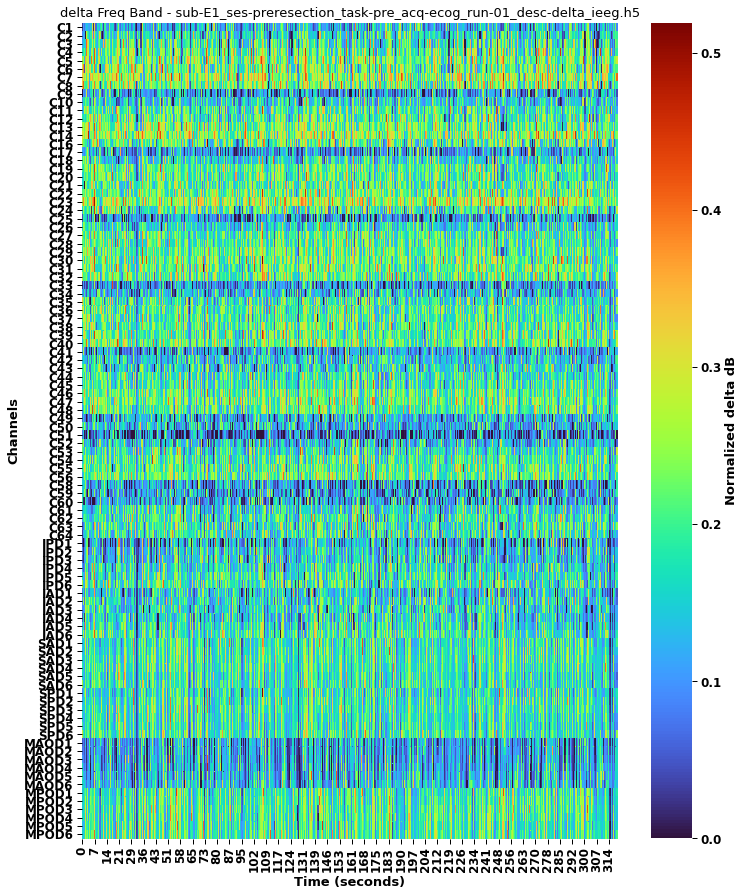

In [43]:
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
sns.set_context("paper", font_scale=1.25)
fig, ax = plot_heatmap(power, deriv_fpath, db=True, normalize=True)
fig.savefig(
    figures_path
    / f"sub-{subject}_ses-{session}_task-{task}_desc-{desc}_normalize-{normalize}_avgdBPower_tfrmap.pdf",
    bbox_inches="tight",
)

# Plot heatmaps in loop

In [20]:
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"

[<AverageTFR | time : [0.000000, 320.123120], freq : [1.000000, 4.000000], nave : 1, channels : 98, ~490.7 MB>]
[<AverageTFR | time : [0.000000, 30.290160], freq : [1.000000, 4.000000], nave : 1, channels : 51, ~24.3 MB>]
Adding new data...
(47, 1, 6208) (51, 1, 6208)
Reordered channels...
Trying to combinederiv computations...
(98, 1, 65600)
(98, 1, 6208)
(98, 1, 71808)


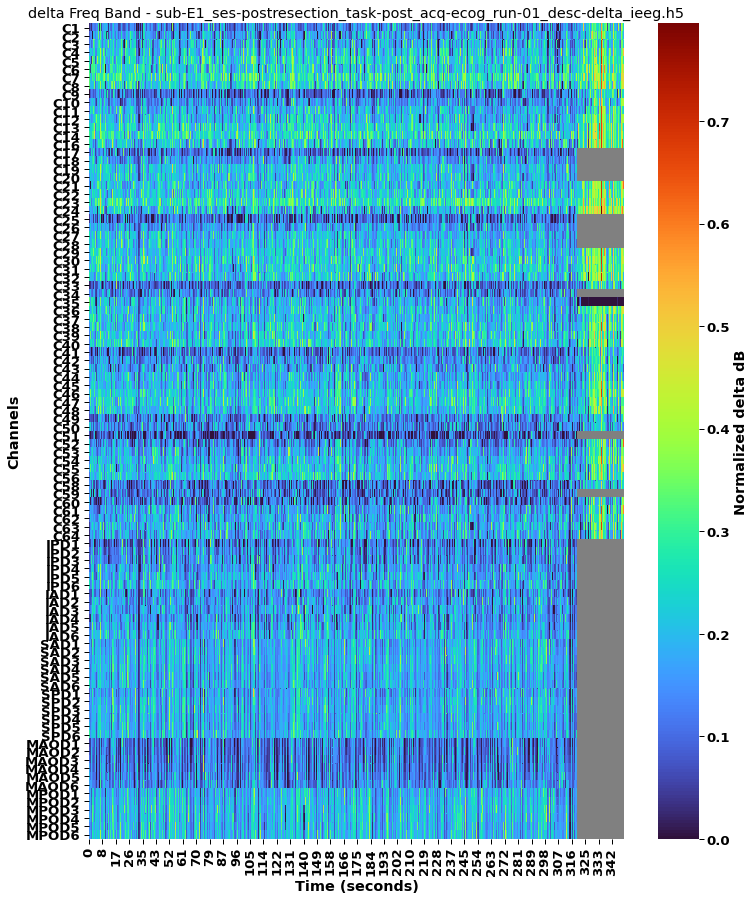

In [143]:
run = "01"
for subject in subjects:
    for desc in freq_bands:
        powers = []

        for session, task in zip(["preresection", "postresection"], ["pre", "post"]):
            bids_path = BIDSPath(
                subject=subject,
                session=session,
                task=task,
                acquisition=acquisition,
                run=run,
                suffix="ieeg",
                extension=".h5",
                check=False,
            )
            deriv_fname = _add_desc_to_bids_fname(bids_path.basename, description=desc)
            deriv_fpath = deriv_path / deriv_fname

            power = read_tfrs(deriv_fpath)
            print(power)
            power = power[0]
            powers.append(power)

        prepost_power = combine_heatmap(powers)
        sns.set_context("paper", font_scale=1.5)
        fig, ax = plot_heatmap(prepost_power, deriv_fpath, db=False, normalize=False)
        fig.savefig(
            figures_path
            / f"sub-{subject}_ses-{session}_task-{task}_desc-{desc}_normalize-{normalize}_prevspost_avgdBPower_tfrmap.pdf",
            bbox_inches="tight",
        )
        break
    break

# Run Statistical Comparisons

In [155]:
200 / 8

25.0

In [156]:
def subsample_blocks(deriv, block_size=None, n_blocks=100, seed=None):
    """Randomly subsample blocks of data."""
    if block_size is None:
        block_size = max(int(len(deriv.times) // (500 * 25)), 10)

    rng = np.random.RandomState(seed)
    sample_idx = np.arange(block_size, len(deriv.times) - block_size)
    blocks = []

    for idx in range(n_blocks):
        # get starting position of the block
        bootstrap_idx = int(rng.choice(sample_idx, size=1, replace=True))

        blocks.append(deriv.data[..., bootstrap_idx : bootstrap_idx + block_size])
    return blocks

In [157]:
def compute_block_bootstrap_stats(
    pre_deriv, post_deriv, subject, df_summ=None, threshold=None
):
    # compute effect size difference with sub-sampling
    pre_blocks = subsample_blocks(pre_deriv)
    post_blocks = subsample_blocks(post_deriv)

    cohensd = []
    stats = []
    pvals = []

    for preb, postb in zip(pre_blocks, post_blocks):
        if threshold is not None:
            preb[np.abs(preb) < threshold] = np.nan
            postb[np.abs(postb) < threshold] = np.nan

        # drop any nans
        preb = preb[~np.isnan(preb)]
        postb = postb[~np.isnan(postb)]

        stat, pvalue = KSample("Dcorr").test(preb, postb)
        stats.append(stat)
        pvals.append(pvalue)

        es = pg.compute_effsize(preb, postb, paired=False, eftype="cohen")

        cohensd.append(es)

        if df_summ is not None:
            df_summ.append([subject, es, stat, pvalue])
    return cohensd, stats, pvals

## Initialize dataframe for plotting over all subjects

In [164]:
# keep track of the dataframe summary
df = pd.DataFrame()

In [165]:
run = "01"
for subject in subjects:
    deriv_chain = Path("tfr") / reference / f"sub-{subject}"
    deriv_path = deriv_root / deriv_chain

    for desc in freq_bands:
        powers = []

        for session, task in zip(["preresection", "postresection"], ["pre", "post"]):
            bids_path = BIDSPath(
                subject=subject,
                session=session,
                task=task,
                acquisition=acquisition,
                run=run,
                suffix="ieeg",
                extension=".h5",
                check=False,
            )
            deriv_fname = _add_desc_to_bids_fname(bids_path.basename, description=desc)
            deriv_fpath = deriv_path / deriv_fname

            power = read_tfrs(deriv_fpath)
            print(power)
            power = power[0]
            powers.append(power)

        # keep track of data frame summary statistics
        df_summ = []

        pre_deriv = powers[0]
        post_deriv = powers[1]

        # compute block-bootstrap statistics
        cohensd, stats, pvals = compute_block_bootstrap_stats(
            pre_deriv, post_deriv, subject=subject, df_summ=df_summ, threshold=threshold
        )

        # create
        subj_df = pd.DataFrame(df_summ, columns=["subject", "es", "stat", "pval"])
        subj_df["desc"] = desc
        if df.empty:
            df = subj_df
        else:
            df = pd.concat((df, subj_df), axis=0)

    # save dataframe
    subj_df.to_csv(
        deriv_path.parent / "pre_vs_post" / f"sub-{subject}_desc-{desc}.csv", index=None
    )
#         break
#     break

[<AverageTFR | time : [0.000000, 320.123120], freq : [1.000000, 4.000000], nave : 1, channels : 98, ~490.7 MB>]
[<AverageTFR | time : [0.000000, 30.290160], freq : [1.000000, 4.000000], nave : 1, channels : 51, ~24.3 MB>]
[<AverageTFR | time : [0.000000, 320.123120], freq : [4.000000, 8.000000], nave : 1, channels : 98, ~490.7 MB>]
[<AverageTFR | time : [0.000000, 30.290160], freq : [4.000000, 8.000000], nave : 1, channels : 51, ~24.3 MB>]
[<AverageTFR | time : [0.000000, 320.123120], freq : [8.000000, 12.000000], nave : 1, channels : 98, ~490.7 MB>]
[<AverageTFR | time : [0.000000, 30.290160], freq : [8.000000, 12.000000], nave : 1, channels : 51, ~24.3 MB>]
[<AverageTFR | time : [0.000000, 320.123120], freq : [12.000000, 30.000000], nave : 1, channels : 98, ~490.7 MB>]
[<AverageTFR | time : [0.000000, 30.290160], freq : [12.000000, 30.000000], nave : 1, channels : 51, ~24.3 MB>]
[<AverageTFR | time : [0.000000, 320.123120], freq : [30.000000, 90.000000], nave : 1, channels : 98, ~490

In [166]:
for subject in subjects:
    print(subject)
    display(df[df["subject"] == subject].describe())

E1


,es,stat,pval
count,600.000000,600.0,6.000000e+02
mean,-0.233371,0.0,3.173105e-01
std,0.191022,0.0,5.555747e-17
min,-0.863306,0.0,3.173105e-01
25%,-0.329131,0.0,3.173105e-01
50%,-0.212972,0.0,3.173105e-01
75%,-0.141547,0.0,3.173105e-01
max,0.471111,0.0,3.173105e-01


E3


,es,stat,pval
count,600.000000,600.0,6.000000e+02
mean,0.104746,0.0,3.173105e-01
std,0.446723,0.0,5.555747e-17
min,-1.443115,0.0,3.173105e-01
25%,-0.137484,0.0,3.173105e-01
50%,0.098741,0.0,3.173105e-01
75%,0.344762,0.0,3.173105e-01
max,1.732194,0.0,3.173105e-01


E4


,es,stat,pval
count,600.000000,600.0,6.000000e+02
mean,0.039067,0.0,3.173105e-01
std,0.499078,0.0,5.555747e-17
min,-2.547017,0.0,3.173105e-01
25%,-0.272242,0.0,3.173105e-01
50%,0.055610,0.0,3.173105e-01
75%,0.352415,0.0,3.173105e-01
max,1.333425,0.0,3.173105e-01


E5


,es,stat,pval
count,600.000000,600.0,6.000000e+02
mean,-0.865612,0.0,3.173105e-01
std,1.086020,0.0,5.555747e-17
min,-4.675842,0.0,3.173105e-01
25%,-1.681396,0.0,3.173105e-01
50%,-0.673370,0.0,3.173105e-01
75%,-0.093863,0.0,3.173105e-01
max,1.894724,0.0,3.173105e-01


E6


,es,stat,pval
count,600.000000,600.0,6.000000e+02
mean,-0.012934,0.0,3.173105e-01
std,0.742741,0.0,5.555747e-17
min,-3.889848,0.0,3.173105e-01
25%,-0.326689,0.0,3.173105e-01
50%,0.147509,0.0,3.173105e-01
75%,0.444247,0.0,3.173105e-01
max,2.284637,0.0,3.173105e-01


E7


,es,stat,pval
count,600.000000,600.0,6.000000e+02
mean,-0.355195,0.0,3.173105e-01
std,0.530402,0.0,5.555747e-17
min,-2.307213,0.0,3.173105e-01
25%,-0.646420,0.0,3.173105e-01
50%,-0.277269,0.0,3.173105e-01
75%,0.002420,0.0,3.173105e-01
max,1.872919,0.0,3.173105e-01


In [167]:
# save the output
df.to_csv(deriv_path.parent / "pre_vs_post" / f"dataframe_results_all.csv", index=None)

# Plot Final Statistical Comparisons

In [36]:
print(pre_deriv)
print(post_deriv)

<DerivativeArray | sub-E7_ses-preresection_task-pre_acq-ecog_run-01_desc-perturbmatrix_ieeg.npy, shape: (111, 606) (111 chs x 606 times) (151.2 s), ~807 kB, data loaded | reference=average | perturbmatrix>
<DerivativeArray | sub-E7_ses-postresection_task-post_acq-ecog_run-01_desc-perturbmatrix_ieeg.npy, shape: (111, 654) (111 chs x 654 times) (163.2 s), ~821 kB, data loaded | reference=average | perturbmatrix>


In [37]:
(figures_path / "boxplot_summaries").mkdir(exist_ok=True)

print(derivtype)

prod


In [178]:
freq = "highgamma"
freq_df = df[df["desc"] == freq]

avg_df = freq_df.groupby(["subject"])["es"].agg([np.average])
fail_mean = avg_df.iloc[0]["average"]

print(fail_mean)

-0.18743958232900848


done


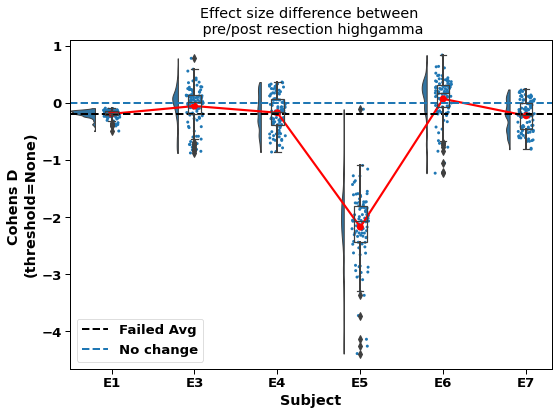

In [179]:
ort = "v"
pal = "Set2"
sigma = 0.2
pal = sns.color_palette(n_colors=1)
sns.set_context("paper", font_scale=1.5)
fig, ax = plt.subplots(figsize=(8, 6))
# sns.swarmplot(x='subject', y='es',
#               order=natsorted(df['subject'].unique()),
#               alpha=0.5, color='black',
#               data=df, ax=ax)
# sns.boxplot(x='subject', y='es', color='gray',
#             order=natsorted(df['subject'].unique()),
#             data=df, ax=ax, boxprops=dict(alpha=0.5))

pt.RainCloud(
    x="subject",
    y="es",
    data=freq_df,
    palette=pal,
    bw=sigma,
    width_viol=0.6,
    ax=ax,
    orient=ort,
    pointplot=True,
)

ax.axhline(fail_mean, ls="--", lw=2, color="black", label="Failed Avg")

# plot horizontal line
ax.axhline(
    [0],
    ls="--",
    lw=2,
    #            color='black',
    label="No change",
)

ax.legend()
ax.set(
    #     ylim=[-1.5, 1.5],
    xlabel="Subject",
    ylabel=f"Cohens D \n(threshold={threshold})",
    title=f"Effect size difference between \n pre/post resection {freq}",
)
fig.tight_layout()
(figures_path / "rainplot_summaries").mkdir(exist_ok=True)
fig.savefig(
    figures_path
    / "rainplot_summaries"
    / f"tfr-{freq}-rainplot-prevspost-{reference}-threshold{threshold}.pdf",
    bbox_inches="tight",
)
print("done")